In [1]:
# Make necessary imports 

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from collections import Counter
import numpy as np
from scipy.stats import randint

In [2]:
# Read the csv file using pandas
df_train = pd.read_csv(r"C:\Users\saina\OneDrive\Desktop\PROJECT_4\train_data_processed.csv")

In [3]:
df_train.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,RegistryKey,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Hour
0,180388628218,0,612,123247,7,6,10,2,15,1,...,1631,635,2251,881,3586,5,31,4,6,6
1,455266534868,88,326,210035,58,43,7,1,32,0,...,1631,635,2251,881,3586,5,242,14,6,3
2,1056561957389,809,58352,712507,423,298,10,1,31,1,...,1631,635,2251,881,3586,5,242,13,6,4
3,1279900258736,92,32992,774301,2,2,1,0,31,1,...,1631,635,2251,881,3586,5,242,10,6,16
4,214748368522,148,4359,188041,9,74,6,2,32,0,...,1631,635,2251,881,3586,5,242,15,6,1


In [4]:
# Splitting data
X= df_train.drop('IncidentGrade',axis=1)
y= df_train['IncidentGrade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Selecting top features using anova 

selector = SelectKBest(score_func=f_classif, k=15)  # Adjust k as needed
X_new = selector.fit_transform(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'EntityType', 'EvidenceRole', 'Sha256', 'IpAddress',
       'AccountSid', 'DeviceName', 'NetworkMessageId', 'CountryCode', 'Day'],
      dtype='object')


In [6]:
# Keeping only the top 15 features
X_new=X[['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'EntityType', 'EvidenceRole', 'Sha256', 'IpAddress',
       'AccountSid', 'DeviceName', 'NetworkMessageId', 'CountryCode', 'Day']]
X_new.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,Sha256,IpAddress,AccountSid,DeviceName,NetworkMessageId,CountryCode,Day
0,0,612,123247,7,6,10,15,1,138268,27,441377,153085,529644,31,4
1,88,326,210035,58,43,7,32,0,138268,360606,22406,153085,529644,242,14
2,809,58352,712507,423,298,10,31,1,138268,360606,441377,153085,529644,242,13
3,92,32992,774301,2,2,1,31,1,138268,360606,441377,153085,529644,242,10
4,148,4359,188041,9,74,6,32,0,138268,360606,449,153085,529644,242,15


# Step 1 : Training and testing with different models and implementing cross validation and hyperparameter tuning using Random Search CV

## Using Stratified sampling and training/testing on 4 models : Logistic Regression, Decision Tree, Random Forest, XGBoost
This is performed on the full dataset containing 9.8 million rows.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Initialize a DataFrame to store evaluation metrics
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Loop through each model, fit it, predict, and collect evaluation metrics
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Create a dictionary to store the metrics for this model
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    # Append metrics to the DataFrame using pd.concat
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
    
    # Print confusion matrix
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# Display the evaluation metrics in tabular format
print("\nEvaluation Metrics Summary:")
print(metrics_df)



Evaluating Random Forest...


C:\Users\saina\AppData\Local\Temp\ipykernel_12680\1174451885.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)



Confusion Matrix for Random Forest:
[[815833   3851   2466]
 [  5573 397605   2735]
 [  5337   3656 651536]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    822150
           1       0.98      0.98      0.98    405913
           2       0.99      0.99      0.99    660529

    accuracy                           0.99   1888592
   macro avg       0.99      0.99      0.99   1888592
weighted avg       0.99      0.99      0.99   1888592


Evaluating XGBoost...

Confusion Matrix for XGBoost:
[[787010  15274  19866]
 [ 46129 343606  16178]
 [ 50298  10232 599999]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92    822150
           1       0.93      0.85      0.89    405913
           2       0.94      0.91      0.93    660529

    accuracy                           0.92   1888592
   macro avg       0.92      0.9

C:\Users\saina\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix for Logistic Regression:
[[588054  30984 203112]
 [245419  43180 117314]
 [217187  29537 413805]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63    822150
           1       0.42      0.11      0.17    405913
           2       0.56      0.63      0.59    660529

    accuracy                           0.55   1888592
   macro avg       0.51      0.48      0.46   1888592
weighted avg       0.53      0.55      0.52   1888592


Evaluating Decision Tree...

Confusion Matrix for Decision Tree:
[[820083   1131    936]
 [  1160 403892    861]
 [   998    878 658653]]

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    822150
           1       1.00      1.00      1.00    405913
           2       1.00      1.00      1.00    660529

    accuracy                           1.00   1888592
  

## Random Forest and Decision Tree Models Perform Well on the Dataset. These models demonstrate good performance, leading to the application of cross-validation for further evaluation

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Loop through each model and perform cross-validation
for model_name, model in models.items():
    print(f"\nCross-validation for {model_name}")
    
    # Perform cross-validation with 5 folds
    cv_scores = cross_val_score(model, X_new, y, cv=5, scoring='accuracy')
    
    # Print each fold’s score
    print("Cross-Validation Scores for each fold:", cv_scores)
    
    # Print the mean and standard deviation of the cross-validation scores
    print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))
    print("Standard Deviation of Cross-Validation Accuracy:", np.std(cv_scores))



Cross-validation for Random Forest
Cross-Validation Scores for each fold: [0.98784544 0.98790792 0.98777342 0.98785656 0.98771094]
Mean Cross-Validation Accuracy: 0.9878188567195922
Standard Deviation of Cross-Validation Accuracy: 6.894753085837411e-05

Cross-validation for Decision Tree
Cross-Validation Scores for each fold: [0.9968781  0.99702053 0.99687704 0.99694269 0.99689716]
Mean Cross-Validation Accuracy: 0.9969231033211429
Standard Deviation of Cross-Validation Accuracy: 5.4215490578729903e-05


## Due to the large size of the dataset, it has become challenging to process and obtain results. Therefore, we sample 500,000 rows from each class using stratification to create balanced training and testing datasets.

In [3]:
# Path to your CSV file
file_path = r"C:\Users\saina\OneDrive\Desktop\PROJECT_4\train_data_processed.csv"

# Target row count per class
target_rows_per_class = 500_000

# Initialize dictionaries to store sampled data for each class
samples_per_class = {0: [], 1: [], 2: []}

# Define chunk size to avoid memory overload
chunk_size = 100_000

# Read the CSV file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # For each class, sample rows if the target has not been reached
    for class_value in samples_per_class.keys():
        # Filter rows of the current class
        class_rows = chunk[chunk['IncidentGrade'] == class_value]
        
        # Calculate how many more rows are needed for this class
        remaining_rows = target_rows_per_class - sum(len(df) for df in samples_per_class[class_value])
        
        # If more rows are needed, sample accordingly
        if remaining_rows > 0:
            samples_per_class[class_value].append(class_rows.sample(n=min(remaining_rows, len(class_rows))))

    # Stop reading further chunks if we’ve collected enough rows for each class
    if all(sum(len(df) for df in samples) >= target_rows_per_class for samples in samples_per_class.values()):
        break

# Concatenate samples to create the final balanced dataset
final_sampled_df = pd.concat([pd.concat(samples) for samples in samples_per_class.values()])

print("Final sampled data shape:", final_sampled_df.shape)
print("Class distribution in final sampled data:\n", final_sampled_df['IncidentGrade'].value_counts())

# Now proceed with model training using final_sampled_df
X = final_sampled_df.drop('IncidentGrade', axis=1)
y = final_sampled_df['IncidentGrade']


Final sampled data shape: (1500000, 28)
Class distribution in final sampled data:
 IncidentGrade
0    500000
1    500000
2    500000
Name: count, dtype: int64


In [4]:
# Keeping the top features and then splitting the dataset into train and test

X_new=X[['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'EntityType', 'EvidenceRole', 'Sha256', 'IpAddress',
       'AccountSid', 'DeviceName', 'NetworkMessageId', 'CountryCode', 'Day']]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42,stratify=y)


## Cross validation for Decsion Tree and Random Forest model with the new sample dataset 

In [15]:
# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Loop through each model and perform cross-validation
for model_name, model in models.items():
    print(f"\nCross-validation for {model_name}")
    
    # Perform cross-validation with 5 folds
    cv_scores = cross_val_score(model, X_new, y, cv=5, scoring='accuracy')
    
    # Print each fold’s score
    print("Cross-Validation Scores for each fold:", cv_scores)
    
    # Print the mean and standard deviation of the cross-validation scores
    print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))
    print("Standard Deviation of Cross-Validation Accuracy:", np.std(cv_scores))



Cross-validation for Random Forest
Cross-Validation Scores for each fold: [0.96391333 0.96415667 0.96351333 0.96438333 0.96380333]
Mean Cross-Validation Accuracy: 0.963954
Standard Deviation of Cross-Validation Accuracy: 0.00029797389893151797

Cross-validation for Decision Tree
Cross-Validation Scores for each fold: [0.97659333 0.97689667 0.97699667 0.97699333 0.97684   ]
Mean Cross-Validation Accuracy: 0.976864
Standard Deviation of Cross-Validation Accuracy: 0.00014780467591461296


## Both Models Perform Well, with Decision Tree Slightly Outperforming Random Forest

## Hyperparameter Tuning with Randomized Search CV for Both Models

In [5]:
# Hyperparameter grid for Random Forest
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

# Hyperparameter grid for Decision Tree
dt_param_dist = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Randomized search for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rf_random_search.fit(X_train, y_train)

# Randomized search for Decision Tree
dt_random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=dt_param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
dt_random_search.fit(X_train, y_train)

# Best models
best_rf = rf_random_search.best_estimator_
best_dt = dt_random_search.best_estimator_

# Evaluation on Training Data
print("\nRandom Forest Training Evaluation:")
rf_train_preds = best_rf.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, rf_train_preds))
print("Confusion Matrix:\n", confusion_matrix(y_train, rf_train_preds))
print("Classification Report:\n", classification_report(y_train, rf_train_preds))

print("\nDecision Tree Training Evaluation:")
dt_train_preds = best_dt.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, dt_train_preds))
print("Confusion Matrix:\n", confusion_matrix(y_train, dt_train_preds))
print("Classification Report:\n", classification_report(y_train, dt_train_preds))

# Evaluation on Test Data
print("\nRandom Forest Test Evaluation:")
rf_test_preds = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, rf_test_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_test_preds))
print("Classification Report:\n", classification_report(y_test, rf_test_preds))

print("\nDecision Tree Test Evaluation:")
dt_test_preds = best_dt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, dt_test_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_test_preds))
print("Classification Report:\n", classification_report(y_test, dt_test_preds))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Random Forest Training Evaluation:
Training Accuracy: 0.9938816666666667
Confusion Matrix:
 [[397393   1736    871]
 [   970 398314    716]
 [  1123   1926 396951]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    400000
           1       0.99      1.00      0.99    400000
           2       1.00      0.99      0.99    400000

    accuracy                           0.99   1200000
   macro avg       0.99      0.99      0.99   1200000
weighted avg       0.99      0.99      0.99   1200000


Decision Tree Training Evaluation:
Training Accuracy: 0.9974466666666667
Confusion Matrix:
 [[399454    324    222]
 [   824 398936    240]
 [   719    735 398546]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    400000
      

# Step 2: Analyzing Feature Importance

### Random Forest model


Feature Importance from Random Forest Model:
OrgId: 0.5124
IncidentId: 0.1172
AlertId: 0.1171
DetectorId: 0.0883
AlertTitle: 0.0797
Category: 0.0338
EntityType: 0.0025
EvidenceRole: 0.0005
Sha256: 0.0016
IpAddress: 0.0024
AccountSid: 0.0055
DeviceName: 0.0010
NetworkMessageId: 0.0033
CountryCode: 0.0010
Day: 0.0336


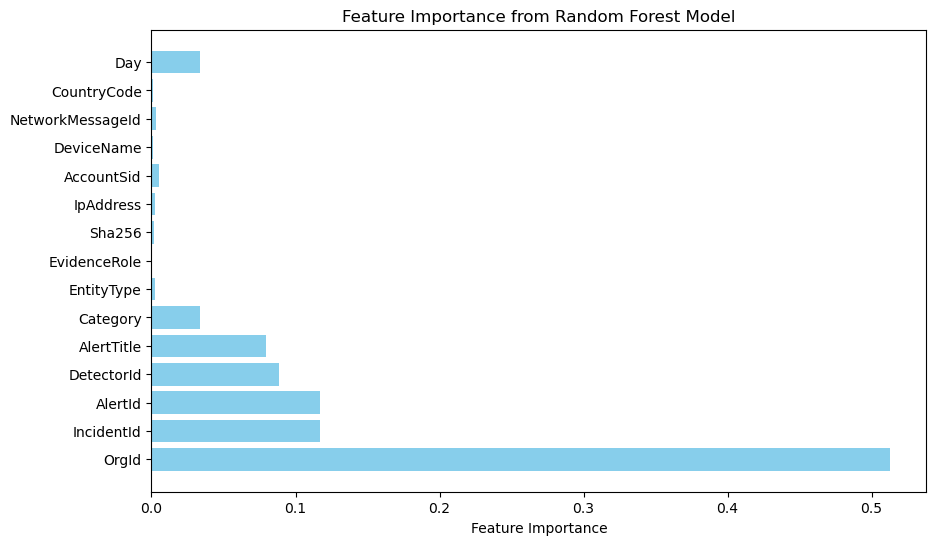

In [14]:
# 1. Model-Specific Feature Importance (for Random Forest)
print("\nFeature Importance from Random Forest Model:")
model_specific_importance = best_rf.feature_importances_
for feature, importance in zip(X_train.columns, model_specific_importance):
    print(f"{feature}: {importance:.4f}")

# Plot model-specific feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, model_specific_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest Model")
plt.show()

### Decision Tree model


Feature Importance from Decision Tree Model:
OrgId: 0.5100
IncidentId: 0.1161
AlertId: 0.1203
DetectorId: 0.0884
AlertTitle: 0.0796
Category: 0.0331
EntityType: 0.0023
EvidenceRole: 0.0007
Sha256: 0.0017
IpAddress: 0.0028
AccountSid: 0.0048
DeviceName: 0.0009
NetworkMessageId: 0.0033
CountryCode: 0.0014
Day: 0.0346


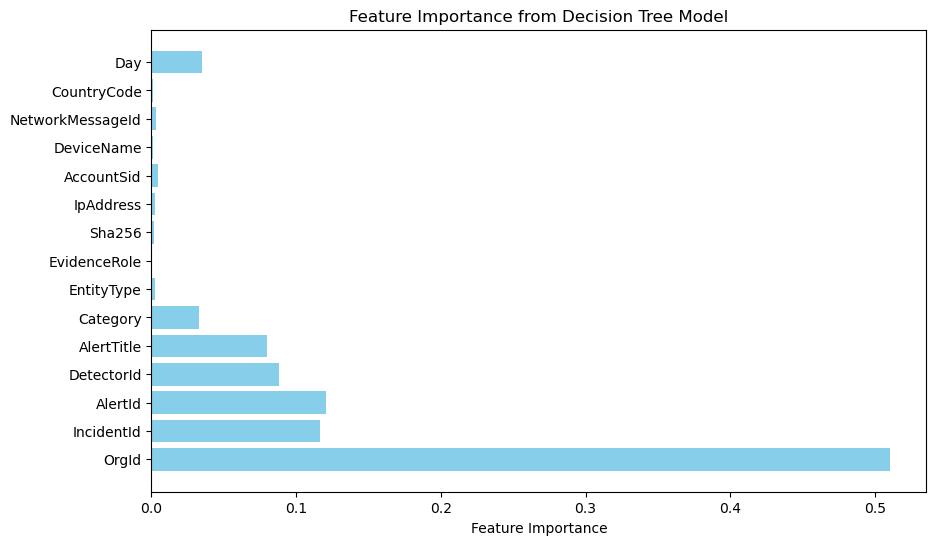

In [15]:
# 1. Model-Specific Feature Importance (for Random Forest)
print("\nFeature Importance from Decision Tree Model:")
model_specific_importance = best_dt.feature_importances_

# Displaying feature importance scores
for feature, importance in zip(X_train.columns, model_specific_importance):
    print(f"{feature}: {importance:.4f}")

# Plot model-specific feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, model_specific_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Decision Tree Model")
plt.show()


# Step 3: Error Analysis 

### Analyzing Errors/Misclassifications in the Random Forest Model

In [27]:
# Identify misclassified instances
misclassified_indices = np.where(y_test != rf_test_preds)[0]

# Print overall misclassification summary
print(f"Total Misclassifications: {len(misclassified_indices)} out of {len(y_test)}")

# Analyze common misclassifications
misclassified_true_labels = y_test.iloc[misclassified_indices]
misclassified_pred_labels = rf_test_preds[misclassified_indices]
misclassifications = list(zip(misclassified_true_labels, misclassified_pred_labels))
misclassification_counts = Counter(misclassifications)

# Print the top 5 most common misclassifications
print("\nTop 5 Most Common Misclassifications:")
for (true_label, pred_label), count in misclassification_counts.most_common(5):
    print(f"True Label: {true_label}, Predicted Label: {pred_label}, Count: {count}")

Total Misclassifications: 5913 out of 300000

Top 5 Most Common Misclassifications:
True Label: 0, Predicted Label: 1, Count: 1370
True Label: 2, Predicted Label: 1, Count: 1241
True Label: 1, Predicted Label: 0, Count: 943
True Label: 2, Predicted Label: 0, Count: 888
True Label: 0, Predicted Label: 2, Count: 774


### Analyzing Errors/Misclassifications in the Decision Tree Model

In [26]:
# Identify misclassified instances
misclassified_indices = np.where(y_test != dt_test_preds)[0]

# Print overall misclassification summary
print(f"Total Misclassifications: {len(misclassified_indices)} out of {len(y_test)}")

# Analyze common misclassifications
misclassified_true_labels = y_test.iloc[misclassified_indices]
misclassified_pred_labels = dt_test_preds[misclassified_indices]
misclassifications = list(zip(misclassified_true_labels, misclassified_pred_labels))
misclassification_counts = Counter(misclassifications)

# Print the top 5 most common misclassifications
print("\nTop 5 Most Common Misclassifications:")
for (true_label, pred_label), count in misclassification_counts.most_common(5):
    print(f"True Label: {true_label}, Predicted Label: {pred_label}, Count: {count}")

Total Misclassifications: 7163 out of 300000

Top 5 Most Common Misclassifications:
True Label: 0, Predicted Label: 1, Count: 1444
True Label: 1, Predicted Label: 0, Count: 1392
True Label: 2, Predicted Label: 1, Count: 1256
True Label: 2, Predicted Label: 0, Count: 1121
True Label: 1, Predicted Label: 2, Count: 995


# Step 4: Final Evaluation on Test Set

In [29]:

df_test = pd.read_csv(r"C:\Users\saina\OneDrive\Desktop\PROJECT_4\test_data_processed.csv")

# Select the important features based on your previous findings
X = df_test[['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
                 'Category', 'EntityType', 'EvidenceRole', 'Sha256', 'IpAddress',
                 'AccountSid', 'DeviceName', 'NetworkMessageId', 'CountryCode', 'Day']]

y = df_test['IncidentGrade']

# Predict using the trained models (best_rf and best_dt)
rf_test_preds = best_rf.predict(X)
dt_test_preds = best_dt.predict(X)

# Evaluate the models

# Random Forest Evaluation
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y, rf_test_preds):.4f}")
print(f"Precision: {precision_score(y, rf_test_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(y, rf_test_preds, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y, rf_test_preds, average='weighted'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y, rf_test_preds))
print("Classification Report:\n", classification_report(y, rf_test_preds))

# Decision Tree Evaluation
print("\nDecision Tree Model Evaluation:")
print(f"Accuracy: {accuracy_score(y, dt_test_preds):.4f}")
print(f"Precision: {precision_score(y, dt_test_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(y, dt_test_preds, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y, dt_test_preds, average='weighted'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y, dt_test_preds))
print("Classification Report:\n", classification_report(y, dt_test_preds))



Random Forest Model Evaluation:
Accuracy: 0.9170
Precision: 0.9180
Recall: 0.9170
F1 Score: 0.9173
Confusion Matrix:
 [[1595877   91505   65513]
 [  58423  811700   32541]
 [  49658   46451 1396220]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92   1752895
           1       0.85      0.90      0.88    902664
           2       0.93      0.94      0.93   1492329

    accuracy                           0.92   4147888
   macro avg       0.91      0.92      0.91   4147888
weighted avg       0.92      0.92      0.92   4147888


Decision Tree Model Evaluation:
Accuracy: 0.9042
Precision: 0.9051
Recall: 0.9042
F1 Score: 0.9045
Confusion Matrix:
 [[1589100   99344   64451]
 [  66335  793027   43302]
 [  71793   52029 1368507]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91   1752895
           1       0.84      0.88      0.86    902664
      